<center><font size = "10"> Week 6 - Single Cell Electrophysiology<center>
<center><font size = "8">Tutorial 03: Parameter Optimization<center>

<font size = "3"><font color = "blue"> In this tutorial you will optimize the soma conductances of a ball and stick cell model.
    
<font size = "3"><font color = "blue">The main goal of the tutorial is that you understand what is an optimization and what are the steps of a genetic algorithm.

# What is Parameter Optimization?
<font size='3'>A fancy name for training the selection of parameter values, which are optimal in some desired sense (eg. minimize an objective function you choose over a dataset you choose).

# 1. Parameters to be optimized.

<font size='3'>First we need to know what do we want to optimize. A parameter can be in two states: frozen and not frozen. When a parameter is frozen it has an exact value, otherwise it only has some bounds but the exact value is not known yet. In this tutorial we will focus on optimizing the parameters at the soma.
    
<font size='3'>Let's create the model

In [1]:
# Load usefull packages
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from neuron import h

--No graphics will be displayed.


In [2]:
# Create sections
soma = h.Section(name='soma')
dend = h.Section(name='dend')

# Topology
dend.connect(soma(1))

# Geometry (frozen parameters)
soma.L = soma.diam = 12.6157 # µm
dend.L = 200                 # µm
dend.diam = 1                # µm
h.define_shape() # Translate into 3D points.

# Biophysics
for sec in h.allsec():
    sec.Ra = 100    # Axial resistance in Ohm * cm (frozen)
    sec.cm = 1      # Membrane capacitance in micro Farads / cm^2 (frozen)

# Insert active Hodgkin-Huxley current in the soma
soma.insert('hh')
for seg in soma:
    seg.hh.gnabar = 0.25  # Sodium conductance in S/cm2. [0, 1] (NOT frozen)
    seg.hh.gkbar = 0.1    # Potassium conductance in S/cm2. [0, 1] (NOT frozen)
    seg.hh.gl = 0.0003    # Leak conductance in S/cm2 (fix)
    seg.hh.el = -54.3     # Reversal potential in mV (fix)

# Insert passive current in the dendrite
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.001  # Passive conductance in S/cm2 (frozen)
    seg.pas.e = -65    # Leak reversal potential mV (frozen)

<font size='3'>So in this case we only have two not-frozen or variable parameters: gnabar and gkbar.

<font size='3'>In the code above we have already asigned default parameters to these variables. Let's see how the cell behaves under two different stimulations during a current clamp experiment.

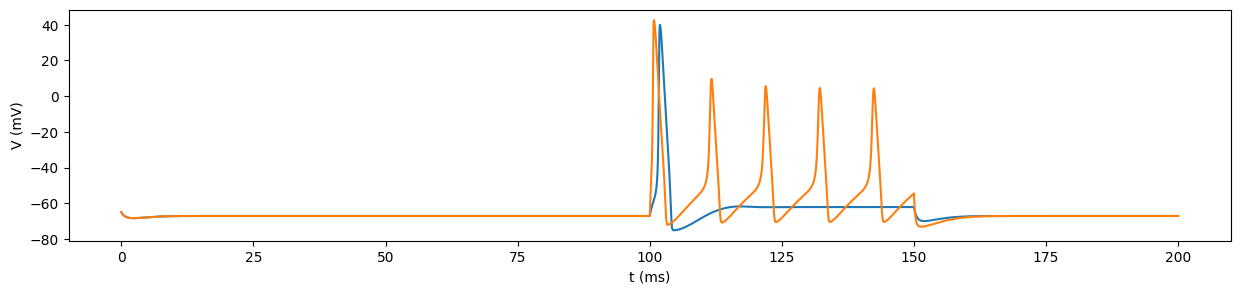

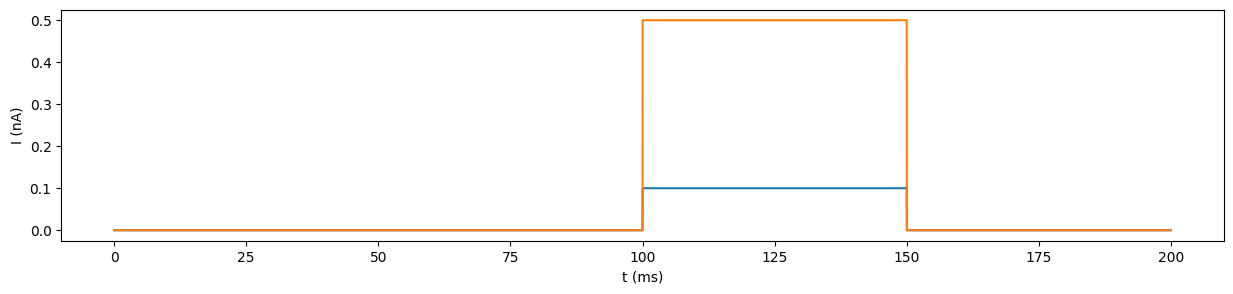

In [3]:
# Inject current steps into the soma
stim_amp = [0.1, 0.5]

# Define plots
fig1, ax1 = plt.subplots(figsize=(15,3))
ax1.set(xlabel = 't (ms)', ylabel = 'V (mV)')

fig2, ax2 = plt.subplots(figsize=(15,3))
ax2.set(xlabel = 't (ms)', ylabel = 'I (nA)')

# Stimulation
for sa in stim_amp:  
    # Place a stimulation electrode in the middle of the soma
    stim = h.IClamp(soma(0.5))         
    stim.delay = 100   # stim delay (ms)
    stim.dur = 50      # stim duration (ms)
    stim.amp = sa      # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(200)
    
    ax1.plot(rec_t, rec_v_soma)
    ax2.plot(rec_t, rec_i)

<font size='3'>We see that for stim_amp = 0.1 nA the cell fires one action potential, while if stim_amp = 0.5 nA the cell fires 5 Action potentials

# 2. Optimize cell conductances through a genetic algorithm

<font size='3'>Now, instead of asigning default values for the conductances, we will try to find the conductances that make our cell behavies as we want. We will find the optimal values by using a genetic algorithm (GA).

<font size='3'>The GA is a method for solving both constrained and unconstrained optimization problems that is based on natural selection, the process that drives biological evolution. The genetic algorithm repeatedly modifies a population of individual solutions. At each step, the genetic algorithm selects individuals at random from the current population to be parents and uses them to produce the children for the next generation. Over successive generations, the population "evolves" toward an optimal solution.

<font size='3'>Let's start from zero.

<font size='5'><font color='red'>RESTART YOUR KERNEL

In [1]:
# Load usefull packages
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from neuron import h

# Cretae ball and stick model
# Create sections
soma = h.Section(name='soma')
dend = h.Section(name='dend')

# Topology
dend.connect(soma(1))
# Geometry
soma.L = soma.diam = 12.6157 # microns
dend.L = 200                 # microns
dend.diam = 1                # microns
h.define_shape() # Translate into 3D points.

# Biophysics
for sec in h.allsec():
    sec.Ra = 100    # Axial resistance in Ohm * cm
    sec.cm = 1      # Membrane capacitance in micro Farads / cm^2

# Insert active Hodgkin-Huxley current in the soma
# Now we won't include the values for gkbar and gnabar
soma.insert('hh')
for seg in soma:
    #seg.hh.gnabar = 0.25  # Sodium conductance in S/cm2. [0, 1]
    #seg.hh.gkbar = 0.1  # Potassium conductance in S/cm2. [0, 1]
    seg.hh.gl = 0.0003    # Leak conductance in S/cm2
    seg.hh.el = -54.3     # Reversal potential in mV

# Insert passive current in the dendrite
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.001  # Passive conductance in S/cm2
    seg.pas.e = -65    # Leak reversal potential mV
    
stim = h.IClamp(soma(0.5))         
stim.delay = 10   # stim delay (ms)
stim.dur = 50  # stim duration (ms)

--No graphics will be displayed.


In [2]:
import efel

# Create a function of the simulation that will give us the result for the different population members
def stimulation(amp, plot=False):
   
    stim.amp = amp    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(60)
    
    trace = {'T': rec_t, 'V': rec_v_soma, 'stim_start': [stim.delay], 'stim_end': [stim.delay + stim.dur]}
    if plot:
        plt.plot(rec_t, rec_v_soma)
    feature_values = efel.getFeatureValues([trace], ['Spikecount'])[0]
    
    return feature_values

# RUN to test
feat = stimulation(0.5)
print(feat['Spikecount'][0])
    

2


/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_9475/1001007607.py:26: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues([trace], ['Spikecount'])[0]


## Step 1: Create a starting random population

<font size='3'>The first step will be to create a random population of [gnabar, gkbar], knowing that the values for both variables are between 0 and 1.

In [3]:
import numpy as np
from numpy import random
import efel


def create_starting_population(gna_min, gna_max, gk_min, gk_max, pop_size):
    # Set up an initial array of all zeros
    return np.array(list(zip(
        np.random.uniform(gna_min, gna_max, size=pop_size),
        np.random.uniform(gk_min, gk_max, size=pop_size))))


pop = create_starting_population(0, 1, 0, 1, 10)
print (pop)

[[9.80282439e-01 2.96195886e-01]
 [7.04464343e-01 6.84048596e-01]
 [9.06475650e-01 6.23753125e-01]
 [5.80924380e-01 5.33168493e-02]
 [1.00494959e-04 3.19695052e-01]
 [2.99797940e-01 8.12389894e-03]
 [5.75836831e-01 8.38008077e-01]
 [5.18298386e-01 1.96711530e-01]
 [1.15176161e-01 7.82376760e-01]
 [4.27446305e-01 8.89096406e-01]]


## Step 2: Calculate fitness of population

<font size='3'>In GAs we refer to how good each individual in the population is as ‘fitness’. The calculate_fitness function will be the evaluation procedure you wish to apply in your algorithm. In this example we are going to return the negative absolute difference between the spike counts observed in a phenotype and the spike counts expected based on experiments. 

In [4]:
def individual_fitness(gene, goal1, stim_amp1, goal2, stim_amp2, plot=False):
    gna = gene[0]
    gk = gene[1]
    # Introduce mechanisms in the ball and stick model
    #soma.insert('hh')
    for seg in soma:
        seg.hh.gnabar = gna  # Sodium conductance in S/cm2. [0, 1]
        seg.hh.gkbar = gk  # Potassium conductance in S/cm2. [0, 1]
    fits = []
    for g, st in zip([goal1, goal2], [stim_amp1, stim_amp2]):
        spike_count = stimulation(st, plot=plot) 
        value = spike_count['Spikecount'][0]
        fit = np.abs(g - value)
        fits.append(-fit)
    return np.mean(fits)

def calculate_fitness(population, goal1, stim_amp1, goal2, stim_amp2):
    return np.array([individual_fitness(individual, goal1, stim_amp1, goal2, stim_amp2)
                     for individual in population])


fit_score = calculate_fitness(pop, 1, 0.1, 5, 0.5)
print(fit_score)

[ 0.  -2.5 -2.5 -3.5 -3.  -2.5 -2.5  0.  -3.  -2.5]


/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_9475/1001007607.py:26: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues([trace], ['Spikecount'])[0]


## Step 3: Choosing individuals breed
<font size='3'>Genetic algorithms mimic biology in that the individuals with the best fitness scores are most likely to breed and pass on their genes. But we do not simply take all the best individuals from our population to breed, as this might risk getting stuck in a local optimum. Rather, we use a method that means better individuals are moire likely to breed, but low fitness individuals at times may be chosen to breed.

<font size='3'> In this case, the probability of an individual to be chosen will be proportional to its score minus the worst score.

In [5]:
def select_parents(population, scores):
    probs = scores - scores.min() + 1e-10 # avoid div by 0 error when population is homogenous
    probs /= probs.sum()
    return population[
        np.random.choice(
            np.arange(len(population)),
            size=(len(population)//2, 2),
            p=probs)]

parents = select_reproduction(pop, fit_score)
parents

NameError: name 'select_reproduction' is not defined

## Step 4: Producing children from parents – crossover

<font size='3'>When two individuals are chosen, the next step is to produce ‘children’ from them. We produce these children by ‘crossover’ mix of their values. One ‘child’ will take the gnabar from parent 1 and gkbar from parent 2. The result is a mix of "genes" from each parent. The second ‘child’ will be the opposite of this.

<font size='3'>It is possible to have more than one crossover point, but we will keep it simple and have a single crossover point.

In [6]:
def breed_by_crossover(parents):
    out = []
    for parent1, parent2 in parents:
        child1 = [parent1[0], parent2[1]]
        child2 = [parent2[0], parent1[1]]
        out.append(child1)
        out.append(child2)
    return np.array(out)


children = breed_by_crossover(parents)

NameError: name 'parents' is not defined

## Step 5: Random mutation of genes

<font size='3'>In evolution sometimes genes are copied incorrectly. This change may be harmful or beneficial. We mimic this by having a certain probability of that a conductance ("gene") becomes switched.

<font size='3'>Typically this probability is low (e.g. 0.005), though it can be made to be flexible (e.g. increase mutation rate if progress has stalled)

In [7]:
def randomly_mutate_population(population, mutation_probability, mutation_size=0.1):  
    mutates = np.random.uniform(0, 1, size=population.shape) < mutation_probability
    population[mutates] += np.random.normal() * mutation_size
    population = np.maximum(population, 0)

    
print(children)

randomly_mutate_population(children, 0.75)
print(children)


NameError: name 'children' is not defined

## Step 6: Putting it all together

<font size='3'>We’ve defined all the functions we need. Now let’s put it all together.
    
Because our target and therefore score is discrete (integer), there are no soft gradients to guide the algorithm and it can be very unstable.
That is why we do one thing extra here: we always keep the the top performing individual from the previous generations, a strategy termed "Elitism"

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_9475/1001007607.py:26: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues([trace], ['Spikecount'])[0]
 70%|███████   | 7/10 [00:00<00:00,  7.33it/s]exp(817918) out of range, returning exp(700)
exp(454398) out of range, returning exp(700)
exp(408958) out of range, returning exp(700)
exp(817919) out of range, returning exp(700)
No more errno warnings during this execution
100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


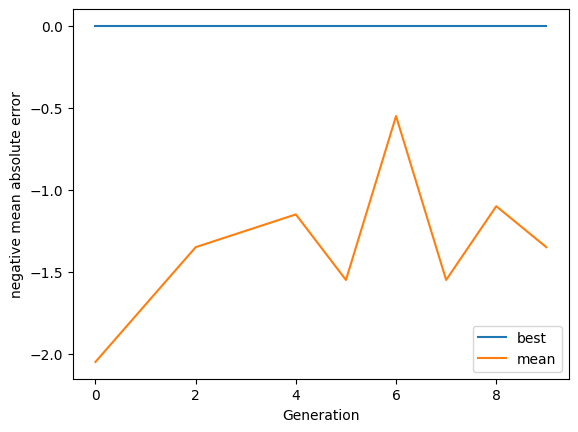

In [8]:
# Set general parameters
from tqdm import tqdm
population_size = 10
maximum_generation = 10

gna_min = 0.0
gna_max = 1
gk_min = 0.0
gk_max = 1
mutation_rate = 0.5
stim_amp1 = 0.1 # nA
goal1 = 1 # 1 spikes is our goal
stim_amp2 = 0.5 # nA
goal2 = 5 # 5 spikes is our goal


# RUN
population = create_starting_population(gna_min, gna_max, gk_min, gk_max, population_size)
pop_scores = calculate_fitness(population, goal1, stim_amp1, goal2, stim_amp2)
top_performer = population[np.argmax(pop_scores)]    

mean_scores = []
best_scores = []
for generation in tqdm(range(maximum_generation)):
    parents = select_parents(population, pop_scores)
    population = breed_by_crossover(parents)
    randomly_mutate_population(population, mutation_rate)
    # elitism!
    population[0] = top_performer
    pop_scores = calculate_fitness(population, goal1, stim_amp1, goal2, stim_amp2)
    mean_scores.append(pop_scores.mean())
    best_scores.append(pop_scores.max())
    top_performer = population[np.argmax(pop_scores)]
    

# Plot progress
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(best_scores, label='best')
plt.plot(mean_scores, label='mean')
plt.legend()
plt.xlabel('Generation')
plt.ylabel('negative mean absolute error')
plt.show()

# Optimizing is not a simple problem.

<font size = "3">This is only a very simple example of what an optimization is, and it gave us many different solutions. Usually we will optimize many more parameters together with respect to many more electrophysiological features. This makes it a very complex task, and it will give us only few potential solutions. As this is such a big problem, there are dedicated libraries such as [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) (read the docs [here](https://bluepyopt.readthedocs.io/en/latest/)). BluePyOpt is an extensible framework for data-driven model parameter optimisation that wraps and standardizes several existing open-source tools. It simplifies the task of creating and sharing these optimisations, and the associated techniques and knowledge.
    
Often, it is not possible to find a good solution for all the desired electrophysiological features, and you instead find a range of approximate solutions with different strengths and weaknesses.